<a href="https://colab.research.google.com/github/JelenaKitanovic/qa_system_covid/blob/main/IR_JelenaKitanovic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem za pretrazivanje informacija o virusu COVID-19 implementiran koriscenjem Haystack framework-a

Cilj ovog projekta je bio da izgradi sistem za odgovore na pitanja (tzv. QA system) koji bi na postavljeno pitanje pronasao odgovore medju dostupnim dokumentima. Za realizaciju ovog projekta, koriscen je [Haystack framework](https://haystack.deepset.ai/overview/intro) koji omogucava BLABLA.

U ovom projektu koriscen je podskup skupa podataka 
[COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Originalni skup se sastoji od preko 500,000 strucnih radova, od kojih je preko 200,000 o COVID-19, SARS-CoV-2, i slicnim virusima. 

Napomena: Radi lakseg treniranja i reprodukcije programa, prilkom izrade ovog projekta koriscen je podskup od oko 10,000 radova. Folder sa tim radovima mozete pronaci na ovoj adresi: ///Moj drive

## Ucitavanje skupa podataka

Kako su podaci u navedenom direktorijumu u json formatu, potrebno je da iz njih izvucemo informacije koje nam trebaju kao i da prilagodimo format onome koji nama odgovara. 

Za dalju analizu bice nam dovoljan naziv rada (title), sazetak (abstract), sam tekst rada (full_text) i imena autora (authors).

In [2]:
import numpy as np
import pandas as pd
import os
import json
import re
from tqdm import tqdm

directory_path = "/content/drive/MyDrive/COVID"
docs=[]
counts=0

for file in tqdm(os.listdir(directory_path)):
  file_path = directory_path + f"/{file}"
  json_content = json.load(open(file_path, "rb"))
  
  paper_id = json_content['paper_id']
  title = json_content['metadata']['title']    
  authors = ''
  for author in json_content['metadata']['authors']:
    authors = authors + author['first'] + ' ' + author['last'] + ', '
  authors = authors[:-2]
  try:
    abstract = json_content['abstract'][0]['text']
  except:
    abstract = ''
            
  full_text = ''
  for text in json_content['body_text']:
    full_text += text['text']       
  docs.append([paper_id, title, abstract, full_text, authors])  

df = pd.DataFrame(docs,columns=['paper_id','title','abstract','full_text', 'authors'])

100%|██████████| 7120/7120 [09:16<00:00, 12.79it/s]


In [3]:
print('Dimenzije skupa podataka:', df.shape)
print('Pregled prvih par redova:')

df.head()

Dimenzije skupa podataka: (7120, 5)
Pregled prvih par redova:


,paper_id,title,abstract,full_text,authors
0,f4151bf1d61e7808033d59606f364c02d41234ed,Akute bilaterale Vestibulopathie nach SARS-CoV...,"Wir berichten über eine 68-jährige Patientin, ...","Einschränkend bleibt natürlich festzustellen, ...",Florian Sachse
1,f42961a84c4587d2adac0afecd40abcfb0ce989d,Nursing Informatics: A Core Competency for the...,This chapter provides the reader with a summar...,Learning Objectives for the Chapter 1. Underst...,"Pamela Hussey, Kathryn Hannah, P Hussey, P Hannah"
2,f40856d6d07cfe364cffb9b4d00b7a8bc40cf679,Epidemic Investigation,,One of the key roles of public health is to ma...,"Els Mathieu, Yao Sodahlon"
3,f42578b823280a3931165040e8a79b23470df0de,"Structure, activity and inhibition of human TM...","9 Transmembrane protease, serine 2 (TMPRSS2) h...",. Engineered activation and structural charact...,"Bryan Fraser#, Serap Beldar#, Almagul Seitova,..."
4,f412033f08fe73d4affcfb381114f4ad306d7f07,HSV Forms an HCMV-like Viral Assembly Center i...,Herpes simplex virus (HSV) is a neuroinvasive ...,It is commonly observed that viruses concentra...,"Shaowen White, Hiroyuki Kawano, N Charles Hara..."


In [4]:
df.describe()

,paper_id,title,abstract,full_text,authors
count,7120,7120,7120,7120,7120
unique,7116,6268,4992,7109,6432
top,f56225bd8d7ba19728b5bb28b3f97372477f8450,,,The nuclear receptor heterodimers of liver X r...,
freq,2,748,2086,3,658


In [5]:
df.drop_duplicates()

,paper_id,title,abstract,full_text,authors
0,f4151bf1d61e7808033d59606f364c02d41234ed,Akute bilaterale Vestibulopathie nach SARS-CoV...,"Wir berichten über eine 68-jährige Patientin, ...","Einschränkend bleibt natürlich festzustellen, ...",Florian Sachse
1,f42961a84c4587d2adac0afecd40abcfb0ce989d,Nursing Informatics: A Core Competency for the...,This chapter provides the reader with a summar...,Learning Objectives for the Chapter 1. Underst...,"Pamela Hussey, Kathryn Hannah, P Hussey, P Hannah"
2,f40856d6d07cfe364cffb9b4d00b7a8bc40cf679,Epidemic Investigation,,One of the key roles of public health is to ma...,"Els Mathieu, Yao Sodahlon"
3,f42578b823280a3931165040e8a79b23470df0de,"Structure, activity and inhibition of human TM...","9 Transmembrane protease, serine 2 (TMPRSS2) h...",. Engineered activation and structural charact...,"Bryan Fraser#, Serap Beldar#, Almagul Seitova,..."
4,f412033f08fe73d4affcfb381114f4ad306d7f07,HSV Forms an HCMV-like Viral Assembly Center i...,Herpes simplex virus (HSV) is a neuroinvasive ...,It is commonly observed that viruses concentra...,"Shaowen White, Hiroyuki Kawano, N Charles Hara..."
...,...,...,...,...,...
7115,eac351c792e9a7a4532bcc0bbfd82fd484f230a1,The real life performance of 7 automated anti-...,Objectives: This study was aimed at providing ...,The SARS-CoV-2 pandemic announced by WHO on Ma...,"Jakub Swad Zba, Maciej Bednarczyk, Tomasz Anys..."
7116,eac222eafac840080046008275d66b0fd8ab9004,"Sociodemographic, clinical and laboratory fact...",To identify and quantify associations between ...,"Introduction Since 11 March 2020, when the Wor...","Mario Rivera-Izquierdo Id, María Del, Carmen V..."
7117,eac100f502348d2453dba24547b3f3a6c22829e5,cancers Human Endogenous Retrovirus Reactivati...,"Citation: Petrizzo, A.; Ragone, C.; Cavalluzzo...","Since January 2021, regulatory agencies, such ...","Annacarmen Petrizzo, Concetta Ragone, Beatrice..."
7118,eac85c85c3a2ac1d3fe53e1e3b3fee98f52527ad,Evaluation of preparedness of healthcare stude...,Aim To assess the knowledge and attitude of se...,Since its first detection in Saudi Arabia in 2...,"Mahmoud Elrggal, Nedaa Karami, Bushra Rafea, L..."


In [6]:
df[df['authors'] == '']

,paper_id,title,abstract,full_text,authors
7,f40631c38739955895a09a0796722e29f1bc5512,,,The pandemic of Corona Virus Disease 2019 (COV...,
40,f4597c208f01029c3ff3abbaf444a2d250c75e9e,PLOS ONE Impact of Covid-19 pandemic on obstet...,The advent of Covid-19 pandemic adversely affe...,Short title: Effects of Covid-19 pandemic on o...,
43,f45365ece4607c0d1f38f1d98697f7a32bfe58c2,,,Background: Health care professionals (PS) are...,
47,f4607f104e185f6db161e94363a3315ae2f08f22,,,Technological advances in the field of technic...,
61,f4319d7d36e11d6b29590ea57d9cc339d0cc9048,Supplementary information,1,"(IBA). For further purification, the eluted sa...",
...,...,...,...,...,...
7012,ea21909396f597f8f83b646b2ac492c00d5dbe0d,SUPPLEMENTARY MATERIALS Section 1. Materials a...,,short amplicons libraries) are based on the am...,
7042,eabd83518d5aaf7981eee2ad27f42ec13546642a,,,Viral infections are the most frequent trigger...,
7062,eab573652a7629e060610e609bbc24a256ef51b2,,,. Football continues to treat mental health as...,
7112,eac426bd7401526b6f9e1c1c0803cdccbd76e112,A Multi-Center Randomized Controlled Trial of ...,,whether the mouth is open or closed. HFNC work...,


### Mozemo primetiti da redovi koji nemaju polje autor su uglavnom ili losi dokumenti ili je doslo do neke greske prilikom parsiranja ulaza. Kako imamo dovoljno podataka i bez njih, takve redove cemo ukloniti da nam ne bi kvarili dalju analizu.

In [7]:
clean_dataframe = df[df['authors'] != '']

print("Dimenzije ociscenog skupa podataka: ", clean_dataframe.shape)
print("Pregled prvih nekoliko redova osiscenog skupa podataka: ")
clean_dataframe.head(10)

Dimenzije ociscenog skupa podataka:  (6462, 5)
Pregled prvih nekoliko redova osiscenog skupa podataka: 


,paper_id,title,abstract,full_text,authors
0,f4151bf1d61e7808033d59606f364c02d41234ed,Akute bilaterale Vestibulopathie nach SARS-CoV...,"Wir berichten über eine 68-jährige Patientin, ...","Einschränkend bleibt natürlich festzustellen, ...",Florian Sachse
1,f42961a84c4587d2adac0afecd40abcfb0ce989d,Nursing Informatics: A Core Competency for the...,This chapter provides the reader with a summar...,Learning Objectives for the Chapter 1. Underst...,"Pamela Hussey, Kathryn Hannah, P Hussey, P Hannah"
2,f40856d6d07cfe364cffb9b4d00b7a8bc40cf679,Epidemic Investigation,,One of the key roles of public health is to ma...,"Els Mathieu, Yao Sodahlon"
3,f42578b823280a3931165040e8a79b23470df0de,"Structure, activity and inhibition of human TM...","9 Transmembrane protease, serine 2 (TMPRSS2) h...",. Engineered activation and structural charact...,"Bryan Fraser#, Serap Beldar#, Almagul Seitova,..."
4,f412033f08fe73d4affcfb381114f4ad306d7f07,HSV Forms an HCMV-like Viral Assembly Center i...,Herpes simplex virus (HSV) is a neuroinvasive ...,It is commonly observed that viruses concentra...,"Shaowen White, Hiroyuki Kawano, N Charles Hara..."
5,f40717f7d6802d0df1135e8225b5c3f69e1b726f,How the COVID-19 pandemic will change the futu...,has posed unprecedented healthcare system chal...,"Since December 2019, the Coronavirus disease-1...","Yaseen Arabi, Elie Azoulay, Hasan Al-Dorzi, Ja..."
6,f4202aa37835ea8e52e0230e2c056a99d06d96f9,The misunderstanding of vaccine efficacy,Although the efficacies of vaccines against SA...,The protective effect of a vaccine is typicall...,"K Passerini, A Timberlake, B Pighin, S"
8,f4185f72f8808fa0c927ce358267368866cfa2eb,Characterizing 56 complete SARS-CoV S-gene seq...,Background: The spike glycoprotein (S) gene of...,Since the severe acute respiratory syndrome (S...,"Julian Tang, Jo Cheung, Ida Chu, Margaret Ip, ..."
9,f42669f3577a3f410cff85a4b1ad9ae5a5065c0e,0123456789) 1 3 Journal of Science in Sport an...,It is known that COVID-19 spread mainly from p...,It is known that COVID-19 spread mainly from p...,Francisco Arias
10,f4242f1af7a17ad76cb437f827ef8d1ff291a731,Disease-Suppressive Soils-Beyond Food Producti...,In the pursuit of higher food production and e...,The COVID-19 pandemic is testing the capabilit...,"Somasundaram Jayaraman, &amp; Naorem, Rattan L..."


# Word cloud

There are 4876397 words in the combination of all abstract.


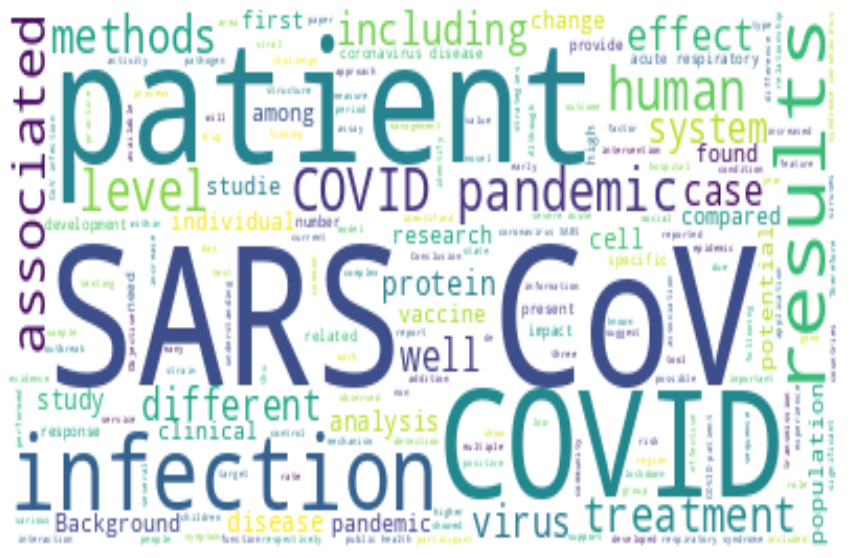

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline 

text = " ".join(title for title in clean_dataframe.abstract)
print("There are {} words in the combination of all abstract.".format(len(text)))

#Izbacujemo tzv. STOPWORDS, to su reci koje se cesto ponavljaju u tekstu, na primer veznici: and i or
stopwords = set(STOPWORDS)
#Izbacujemo jos neke cesto koriscenje reci koje nisu usko vezane za temu istrazivanja
stopwords.update(["et al", "one", "use", "group", "two", "may", "using", "used", "new", "time", "data", "based", "method", "result", "model"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud, interpolation='bilinear', aspect = 'auto')
plt.axis("off")
plt.show()

## Analiza najcescih autora

In [1]:
# authors = ",".join(authors for authors in clean_dataframe['authors'])
# authors_list = authors.split(", ")
# authors_list

NameError: ignored

##Instalacija najnovije verzije Heystack framework-a

In [9]:
!pip install grpcio-tools==1.34.1
!pip install git+https://github.com/deepset-ai/haystack.git

  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-apr1_hq_
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-apr1_hq_


## Ucitavanje potrebnih funkcija i biblioteka

In [10]:
# from haystack import Finder
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http
from haystack.reader.farm import FARMReader
from haystack.reader.transformers import TransformersReader
from haystack.utils import print_answers

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


## Ucitavanje dokumenata u DocumentStore

Haystack trazi odgovore na pitanja u dokumentima koji se nalaze u [DocumentStore](https://haystack.deepset.ai/usage/document-store)-u. Postoji vise implementacija DocumentStore-a (ElasticsearchDocumentStore, SQLDocumentStore, MilvusDocumentStore, InMemoryDocumentStore, etc.)

U ovom projektu je koriscen ElasticsearchDocumentStore zato sto dolazi sa implementiranim algoritmima kao sto su BM25 i full-text queries.

In [11]:
# In Colab / No Docker environments: Start Elasticsearch from source
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )
# wait until ES has started
! sleep 30

In [12]:
# initiating ElasticSearch
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

09/07/2021 14:36:43 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.052s]
09/07/2021 14:36:44 - INFO - elasticsearch -   PUT http://localhost:9200/document [status:200 request:0.342s]
09/07/2021 14:36:44 - INFO - elasticsearch -   PUT http://localhost:9200/label [status:200 request:0.153s]


Da bismo ucitali dokumente u ElasticsearchDocumentStore potrebno je da oni budu u sledecem formatu:
<br>
[
*    {"name": "some-document-name, "text": "abcd"}
*    {"name": "<some-document-name>, "text": "<the-actual-text>"}
*    {"name": "<some-document-name>, "text": "<the-actual-text>"}
<br>
]

(Optionally: you can also add more key-value-pairs here, that will be indexed as fields in Elasticsearch and can be accessed later for filtering or shown in the responses of the Finder)

We will use title column to pass as name and full_text column to pass as the text
# Now, let's write the dicts containing documents to our DB.


In [13]:
# Now, let's write the dicts containing documents to our DB.
dictionary = clean_dataframe[['title', 'full_text']].rename(columns={'title':'name','full_text':'text'}).to_dict(orient='records')
dictionary[:3]


[{'name': 'Akute bilaterale Vestibulopathie nach SARS-CoV-2-Infektion -ein Zufall?',
  'text': 'Einschränkend bleibt natürlich festzustellen, dass auch eine rein zufällige Koinzidenz der bilateralen Vestibulopathie mit der SARS-CoV-2-Infektion vorliegen könnte. Ebenso wären eine autoimmune Genese bei langjähriger rheumatoider Erkrankung oder eine Entstehung infolge von Medikamentennebenwirkungen nicht auszuschließen. Dagegen spricht aber die suffiziente medikamentöse Einstellung und der stabile Krankheitsverlauf über Jahre.Für eine Assoziation mit der SARS-CoV-2-Infektion sprechen der enge zeitliche Zusammenhang und das Vorhandensein von weiteren akuten zentralneurologischen Symptomen (Riechverlust). Vor der SARS-CoV-2-Infektion bestanden weder Schwindelbeschwerden beziehungsweise Gangstörungen noch ein relevanter Riechverlust. Fahrradfahren war eine Woche vor der Infektion noch problemlos möglich. Aktuell wird eine Gehhilfe oder ein Rollator sogar in der Wohnung benutzt.Wir haben der 

In [14]:
document_store.write_documents(dictionary)

09/07/2021 14:37:17 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.905s]
09/07/2021 14:37:20 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.121s]
09/07/2021 14:37:22 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.395s]
09/07/2021 14:37:24 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.170s]
09/07/2021 14:37:27 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.307s]
09/07/2021 14:37:28 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.118s]
09/07/2021 14:37:30 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.163s]
09/07/2021 14:37:33 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.139s]


In [15]:
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)

In [16]:
# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True, context_window_size=1000)
# TransformersReader

09/07/2021 14:37:50 - INFO - farm.utils -   Using device: CUDA 
09/07/2021 14:37:50 - INFO - farm.utils -   Number of GPUs: 1
09/07/2021 14:37:50 - INFO - farm.utils -   Distributed Training: False
09/07/2021 14:37:50 - INFO - farm.utils -   Automatic Mixed Precision: None
09/07/2021 14:37:50 - INFO - filelock -   Lock 140399934554832 acquired on /root/.cache/huggingface/transformers/c40d0abb589629c48763f271020d0b1f602f5208c432c0874d420491ed37e28b.122ed338b3591c07dba452777c59ff52330edb340d3d56d67aa9117ad9905673.lock


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

09/07/2021 14:37:51 - INFO - filelock -   Lock 140399934554832 released on /root/.cache/huggingface/transformers/c40d0abb589629c48763f271020d0b1f602f5208c432c0874d420491ed37e28b.122ed338b3591c07dba452777c59ff52330edb340d3d56d67aa9117ad9905673.lock
09/07/2021 14:37:51 - INFO - filelock -   Lock 140399934554832 acquired on /root/.cache/huggingface/transformers/eac3273a8097dda671e3bea1db32c616e74f36a306c65b4858171c98d6db83e9.084aa7284f3a51fa1c8f0641aa04c47d366fbd18711f29d0a995693cfdbc9c9e.lock


Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

09/07/2021 14:38:00 - INFO - filelock -   Lock 140399934554832 released on /root/.cache/huggingface/transformers/eac3273a8097dda671e3bea1db32c616e74f36a306c65b4858171c98d6db83e9.084aa7284f3a51fa1c8f0641aa04c47d366fbd18711f29d0a995693cfdbc9c9e.lock
Some weights of the model checkpoint at deepset/roberta-base-squad2 were not used when initializing RobertaModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['ro

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

09/07/2021 14:38:08 - INFO - filelock -   Lock 140396741687696 released on /root/.cache/huggingface/transformers/81c80edb4c6cefa5cae64ccfdb34b3b309ecaf60da99da7cd1c17e24a5d36eb5.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock
09/07/2021 14:38:08 - INFO - filelock -   Lock 140396740822416 acquired on /root/.cache/huggingface/transformers/b87d46371731376b11768b7839b1a5938a4f77d6bd2d9b683f167df0026af432.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

09/07/2021 14:38:09 - INFO - filelock -   Lock 140396740822416 released on /root/.cache/huggingface/transformers/b87d46371731376b11768b7839b1a5938a4f77d6bd2d9b683f167df0026af432.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
09/07/2021 14:38:10 - INFO - filelock -   Lock 140396745158544 acquired on /root/.cache/huggingface/transformers/c9d2c178fac8d40234baa1833a3b1903d393729bf93ea34da247c07db24900d0.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock


Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

09/07/2021 14:38:10 - INFO - filelock -   Lock 140396745158544 released on /root/.cache/huggingface/transformers/c9d2c178fac8d40234baa1833a3b1903d393729bf93ea34da247c07db24900d0.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock
09/07/2021 14:38:10 - INFO - filelock -   Lock 140396741432592 acquired on /root/.cache/huggingface/transformers/e8a600814b69e3ee74bb4a7398cc6fef9812475010f16a6c9f151b2c2772b089.451739a2f3b82c3375da0dfc6af295bedc4567373b171f514dd09a4cc4b31513.lock


Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

09/07/2021 14:38:11 - INFO - filelock -   Lock 140396741432592 released on /root/.cache/huggingface/transformers/e8a600814b69e3ee74bb4a7398cc6fef9812475010f16a6c9f151b2c2772b089.451739a2f3b82c3375da0dfc6af295bedc4567373b171f514dd09a4cc4b31513.lock
09/07/2021 14:38:11 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
09/07/2021 14:38:11 - INFO - farm.utils -   Using device: CUDA 
09/07/2021 14:38:11 - INFO - farm.utils -   Number of GPUs: 1
09/07/2021 14:38:11 - INFO - farm.utils -   Distributed Training: False
09/07/2021 14:38:11 - INFO - farm.utils -   Automatic Mixed Precision: None
09/07/2021 14:38:11 - INFO - farm.infer -   Got ya 3 parallel workers to do inference ...
09/07/2021 14:38:11 - INFO - farm.infer -    0    0    0 
09/07/2021 14:38:11 - INFO - farm.infer -   /w\  /w\  /w\
09/07/2021 14:38:11 - INFO - farm.infer -   /'\  / \  /'\
09/07/2021 14:38:11 - INFO - farm.infer -       
09/07/2021 14:38:11 - INFO - f

Stavaljamo Reader i Retreiver u Pipeline.

In [17]:
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)

In [24]:
prediction = pipe.run(query="What is the impact of coronavirus on pregnant women?", top_k_retriever=10, top_k_reader=2)
# What is the impact of coronavirus on babies

09/07/2021 14:41:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.021s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  1.90 Batches/s]


In [26]:
# print_answers(prediction, details="minimal")

print(f"Question: {prediction['query']}")
print("\n")
for i in range(2):
    print(f"#{i+1}")
    print(f"Answer: {prediction['answers'][i]['answer']}")
    print(f"Research Paper: {prediction['answers'][i]['meta']['name']}")
    print(f"Context: {prediction['answers'][i]['context']}")
    print('\n\n')

Question: What is the impact of coronavirus on pregnant women?


#1
Answer: Inequities
Research Paper: Encouraging Physical Activity during and after Pregnancy in the COVID-19 Era, and beyond
Context: growing awareness of the mental and physical benefits of PA that has become apparent during the pandemic provides more opportunity than ever before to speak directly to women and their families about the multiple positive effects of an active lifestyle.The current pandemic has brought health inequalities into particularly sharp focus. Existing inequalities in health, and its determinants, have contributed to the impact of COVID-19 being amplified in already disadvantaged populations [35] . Inequities in the impact of the virus amongst pregnant women have also been reported. For example, a prospective national-population-based cohort study conducted in the UK during the initial months of the pandemic revealed that a high proportion (56%) of pregnant women admitted to hospital with COVID-19

In [ ]:
#@title Unesite pitanje ili skup reci za koji zelite da se izvrsi pretraga:

query = 'Is covid deadly for babies?' #@param {type:"string"}


import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Search")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  prediction = pipe.run(query=query, top_k_retriever=10, top_k_reader=5)
  print(f"Question: {prediction['query']}")
  print("\n")
  for i in range(3):
      print(f"#{i+1}")
      print(f"Answer: {prediction['answers'][i]['answer']}")
      print(f"Research Paper: {prediction['answers'][i]['meta']['name']}")
      print(f"Context: {prediction['answers'][i]['context']}")
      print('\n\n')


button.on_click(on_button_clicked)
display(button, output)
